In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [4]:
pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 24.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 33.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=97ed5e9be4a5eab1e9c84d4ea12e1a86b56193d10f3df347d7347e7399878d45
  Stored in directory: /home/prithvirajnaik/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [10]:
# import the necessary packages
from skimage import measure
# from skimage.measure import compare_ssim
import argparse
import imutils
import cv2
import numpy as np
from matplotlib import pyplot as plt

#For colab cv2 imshow
# from google.colab.patches import cv2_imshow

**Pre Processing**

In [53]:
img1=cv2.imread('/home/prithvirajnaik/prithvi/images/Image1.png')
img2=cv2.imread('/home/prithvirajnaik/prithvi/images/Image2.png')

print(img1.shape,img2.shape)

(313, 238, 3) (310, 230, 3)


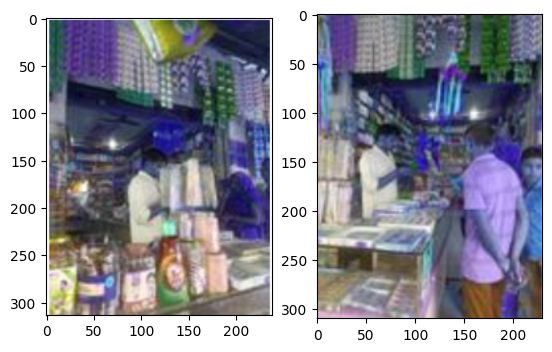

In [55]:
plt.subplot(121)
plt.imshow(img1)

plt.subplot(122)
plt.imshow(img2)

**Brute Force Detection with ORB Descriptors**

In [56]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None) 

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [57]:
# Match descriptors.
matches = bf.match(des1,des2)
print(len(matches))

134


In [58]:
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 25 matches.
img_matches = cv2.drawMatches(img1,kp1,img2,kp2,matches[:25],None,flags=2)
print(len(img_matches))

313


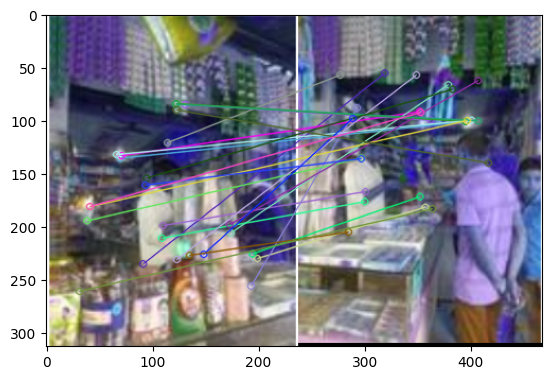

In [59]:
plt.imshow(img_matches)
plt.show()

**Brute-Force Matching with SIFT Descriptors and Ratio Test**

In [60]:
# Create SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

In [61]:
print(matches)

((< cv2.DMatch 0x7fc44005ce90>, < cv2.DMatch 0x7fc44005fe70>), (< cv2.DMatch 0x7fc44f6f7db0>, < cv2.DMatch 0x7fc44008bbd0>), (< cv2.DMatch 0x7fc44008bc30>, < cv2.DMatch 0x7fc44008bbf0>), (< cv2.DMatch 0x7fc44008bc50>, < cv2.DMatch 0x7fc440098c30>), (< cv2.DMatch 0x7fc440098a70>, < cv2.DMatch 0x7fc4400982f0>), (< cv2.DMatch 0x7fc4400985f0>, < cv2.DMatch 0x7fc440098310>), (< cv2.DMatch 0x7fc440098090>, < cv2.DMatch 0x7fc440098930>), (< cv2.DMatch 0x7fc4400983f0>, < cv2.DMatch 0x7fc440098cb0>), (< cv2.DMatch 0x7fc4400988b0>, < cv2.DMatch 0x7fc440098850>), (< cv2.DMatch 0x7fc440098c10>, < cv2.DMatch 0x7fc440098410>), (< cv2.DMatch 0x7fc440098870>, < cv2.DMatch 0x7fc440098430>), (< cv2.DMatch 0x7fc4400987f0>, < cv2.DMatch 0x7fc440098d90>), (< cv2.DMatch 0x7fc440098cd0>, < cv2.DMatch 0x7fc440098d50>), (< cv2.DMatch 0x7fc440098af0>, < cv2.DMatch 0x7fc440098d30>), (< cv2.DMatch 0x7fc440098db0>, < cv2.DMatch 0x7fc440098dd0>), (< cv2.DMatch 0x7fc440098df0>, < cv2.DMatch 0x7fc440098e10>), (< cv2.

In [62]:
# Apply ratio test
good = []
#Less Distance == Better Match
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

In [63]:
print(len(matches),len(good))

#Since both are almost similar images, the difference between them both is nearly 50%

866 7


In [64]:
# cv2.drawMatchesKnn expects list of lists as matches.
sift_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

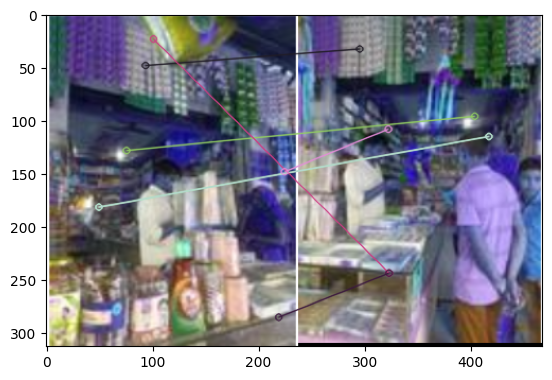

In [65]:
plt.imshow(sift_matches)
plt.show()

**FLANN based Matcher** - Faster than Brute-Force but Accuracy is less than that

In [66]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

#K nearest matches
matches = flann.knnMatch(des1,des2,k=2)

In [67]:
#This block is for making green lines for similar features

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

flann_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

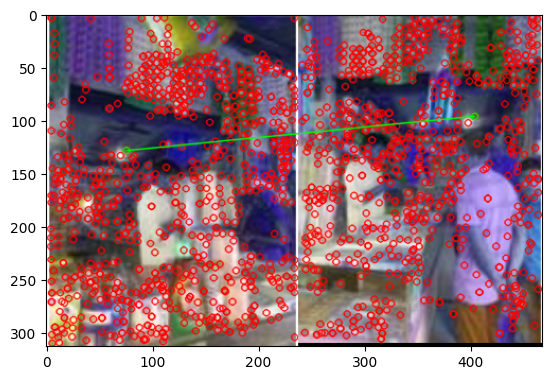

In [68]:
plt.imshow(flann_matches)
plt.show()

In [69]:
#This block is for finding the score

good = []

# ratio test
for match1,match2 in matches:
    if match1.distance < 0.7*match2.distance:
        good.append([match1])

In [70]:
number_keypoints = 0
if len(kp1) >= len(kp2):
  print('img1')
  number_keypoints = len(kp1)
else:
  number_keypoints = len(kp2)
  print('img2')
print(number_keypoints,len(good))

percentage_similarity = len(good) / number_keypoints * 100
print("Similarity: " + str(int(percentage_similarity)) + "\n")

#Since img1 has more features, we can keep img1 and delete img2

img1
866 1
Similarity: 0



In [71]:
print(len(matches),len(good))

#Since both are almost similar images, the difference between them both is nearly 50%

score=(len(good)/len(matches))*100
print(score)

if len(good) < (0.03*len(matches)):
  print("Both images are not same")
else:
  print('Both images are same')

866 1
0.11547344110854503
Both images are not same


**Finding Duplicate images inside a Folder using FLANN Algorithm**

In [43]:
import os
import cv2

folder_path='/content/sample_data/img_folder/'

# Create SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

In [44]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

In [45]:
for i in os.listdir(folder_path):
  i1_name=i
  i=folder_path+i
  img1_temp=cv2.imread(i)
  kp1_temp, des1_temp = sift.detectAndCompute(img1_temp,None)
  for j in os.listdir(folder_path):
    i2_name=j
    j=folder_path+j
    print(i1_name,i2_name)
    if i != j:
      img2_temp=cv2.imread(j)
      kp2_temp, des2_temp = sift.detectAndCompute(img2_temp,None)
      #K nearest matches
      matches_temp = flann.knnMatch(des1_temp,des2_temp,k=2)

      good_temp = []
      # ratio test
      for match1,match2 in matches_temp:
        if match1.distance < 0.7*match2.distance:
          good_temp.append([match1])
      number_keypoints_temp = 0

      if len(kp1_temp) >= len(kp2_temp):
        number_keypoints_temp = len(kp1_temp)
        del_img= i2_name
      else:
        number_keypoints_temp = len(kp2_temp)
        del_img= i1_name
      print(number_keypoints_temp,len(good_temp))

      percentage_similarity = len(good_temp) / number_keypoints_temp * 100
      print("Similarity: " + str(int(percentage_similarity)) )

      if int(percentage_similarity) > 3:
        print('Images ' +i1_name+ ' and ' +i2_name+ ' are duplicates and we can delete '+del_img + "\n" )
      else:
        print('Images ' +i1_name+ ' and ' +i2_name+ ' are not duplicates' + "\n")


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/img_folder/'